# Lesson 3: Federated LLM Fine-tuning

Welcome to Lesson 3!

To access the `requirements.txt` and `utils` files for this course, go to `File` and click `Open`.

#### 1. Import packages and utilities

In [2]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
import flwr as fl
from flwr_datasets import FederatedDataset
from flwr_datasets.partitioner import IidPartitioner
from datasets import load_dataset
from flwr.client.mod import fixedclipping_mod
from flwr.server.strategy import (
    DifferentialPrivacyClientSideFixedClipping
)
from utils_fl.utils import * 
from utils_fl.LLM import LLM_fl
from utils_fl.LLM import get_fireworks_api_key,load_env

* Load configuration.

In [3]:
cfg = get_config("federated")

print_config(cfg)

dataset:
  name: medalpaca/medical_meadow_medical_flashcards
model:
  name: EleutherAI/pythia-14m
  quantization: 4
  gradient_checkpointing: true
  use_fast_tokenizer: true
  lora:
    peft_lora_r: 16
    peft_lora_alpha: 64
    target_modules: null
train:
  num_rounds: ${flower.num_rounds}
  save_every_round: 5
  learning_rate_max: 5.0e-05
  learning_rate_min: 1.0e-06
  seq_length: 512
  padding_side: left
  evaluate_split: false
  training_arguments:
    output_dir: null
    learning_rate: null
    disable_tqdm: true
    per_device_train_batch_size: 2
    gradient_accumulation_steps: 1
    logging_steps: 5
    num_train_epochs: 3
    max_steps: 1
    report_to: null
    save_steps: 1000
    save_total_limit: 10
    gradient_checkpointing: ${model.gradient_checkpointing}
    lr_scheduler_type: constant
flower:
  num_clients: 20
  num_rounds: 2
  fraction_fit: 0.2
  client_resources:
    num_cpus: 2
    num_gpus: 0.0
  dp:
    noise_mult: 0.02
    clip_norm: 0.5



#### 2. Dataset partition

In [4]:
partitioner = IidPartitioner(num_partitions=cfg.flower.num_clients)

In [5]:
partitioner

In [6]:
cfg.dataset.name

'medalpaca/medical_meadow_medical_flashcards'

In [7]:
fds = FederatedDataset(
    dataset=cfg.dataset.name,
    partitioners={"train": partitioner}
)

partition_zero = fds.load_partition(0) 

format_dataset(partition_zero)

Dataset({
    features: ['instruction', 'response'],
    num_rows: 1698
})

In [8]:
fds

In [9]:
partition_zero

Dataset({
    features: ['input', 'output', 'instruction'],
    num_rows: 1698
})

In [10]:
dataset_test =  format_dataset(partition_zero)

# Mostrar los primeros 5 elementos
for i in range(5):
    print(dataset_test[i])

{'instruction': 'What type of injury to the arm/elbow most often leads to supracondylar fractures?', 'response': 'Supracondylar fractures most often occur after hyperextension injuries of the arm/elbow.'}
{'instruction': 'Which cell cycle regulator is encoded by the CCND1 proto-oncogene, and what is its function?', 'response': 'The CCND1 proto-oncogene encodes for the cell cycle regulator Cyclin D1, which stimulates cell cycle progression.'}
{'instruction': 'What is the endocrine effect of glucose-insulinotropic peptide in response to an oral glucose load, specifically in terms of its effect on the release of a certain hormone?', 'response': 'Glucose-insulinotropic peptide causes increased release of insulin in response to an oral glucose load through its endocrine effect.'}
{'instruction': 'What is the remnant of the umbilical vein and where is it contained?', 'response': 'The remnant of the umbilical vein is the ligamentum teres hepatis, which is contained in the falciform ligament.'

In [11]:
dataset_test

Dataset({
    features: ['instruction', 'response'],
    num_rows: 1698
})

* Visualize the data partition.

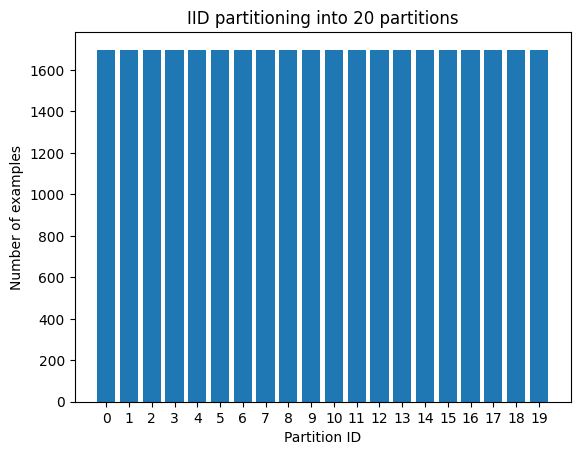

In [12]:
visualize_partitions(fds)

#### 3. Client and Server

* Load the tokenizer and other components.

In [13]:
(
tokenizer,
data_collator,
formatting_prompts_func,
) = get_tokenizer_and_data_collator_and_propt_formatting(
    cfg.model.name, 
    cfg.model.use_fast_tokenizer,
    cfg.train.padding_side,
)

In [14]:
formatting_prompts_func

<function utils_fl.utils.formatting_prompts_func(example)>

* Define the client.

In [15]:
cfg.train

{'num_rounds': '${flower.num_rounds}', 'save_every_round': 5, 'learning_rate_max': 5e-05, 'learning_rate_min': 1e-06, 'seq_length': 512, 'padding_side': 'left', 'evaluate_split': False, 'training_arguments': {'output_dir': None, 'learning_rate': None, 'disable_tqdm': True, 'per_device_train_batch_size': 2, 'gradient_accumulation_steps': 1, 'logging_steps': 5, 'num_train_epochs': 3, 'max_steps': 1, 'report_to': None, 'save_steps': 1000, 'save_total_limit': 10, 'gradient_checkpointing': '${model.gradient_checkpointing}', 'lr_scheduler_type': 'constant'}}

In [16]:
cfg.model

{'name': 'EleutherAI/pythia-14m', 'quantization': 4, 'gradient_checkpointing': True, 'use_fast_tokenizer': True, 'lora': {'peft_lora_r': 16, 'peft_lora_alpha': 64, 'target_modules': None}}

In [17]:
save_path = "./my_fl_model"
client = fl.client.ClientApp(
    client_fn=gen_client_fn(
        fds,
        tokenizer,
        formatting_prompts_func,
        data_collator,
        cfg.model, 
        cfg.train, 
        save_path,
    ),
    mods=[fixedclipping_mod] 
)

In [18]:
type(client)

flwr.client.client_app.ClientApp

In [19]:
cfg.train

{'num_rounds': '${flower.num_rounds}', 'save_every_round': 5, 'learning_rate_max': 5e-05, 'learning_rate_min': 1e-06, 'seq_length': 512, 'padding_side': 'left', 'evaluate_split': False, 'training_arguments': {'output_dir': None, 'learning_rate': None, 'disable_tqdm': True, 'per_device_train_batch_size': 2, 'gradient_accumulation_steps': 1, 'logging_steps': 5, 'num_train_epochs': 3, 'max_steps': 1, 'report_to': None, 'save_steps': 1000, 'save_total_limit': 10, 'gradient_checkpointing': '${model.gradient_checkpointing}', 'lr_scheduler_type': 'constant'}}

In [20]:
cfg.model.lora.target_modules

> Note: The ```gen_client_fn``` function is provided for your use. You can find it in the utils folder > ```utils.py```

* Define the server function and add Differential Privacy.

In [21]:
##### Definir la estrategia planificada
from transformers.modeling_outputs import SequenceClassifierOutput
from torch import nn
import torch

class Distillation(nn.Module):
    def __init__(self, teacher_model, student_model):
        super(Distillation, self).__init__()
        self.teacher = teacher_model
        self.student = student_model
        self.kl_div_loss = nn.KLDivLoss(reduction="batchmean")
        
    def forward(self, input_ids=None, attention_mask=None, labels=None):
        # Solo obtener logits del teacher
        with torch.no_grad():
            t_outputs = self.teacher(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            t_logits = t_outputs.logits
        
        # Obtener logits del student
        s_outputs = self.student(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        s_logits = s_outputs.logits
        s_loss = s_outputs.loss
        
        # Distillation loss simplificada
        temperature = 2.0
        loss_kl = self.kl_div_loss(
            F.log_softmax(s_logits / temperature, dim=-1),
            F.softmax(t_logits / temperature, dim=-1)
        ) * (temperature ** 2)
        
        # Combinar pérdidas
        total_loss = 0.7 * s_loss + 0.3 * loss_kl
        
        return SequenceClassifierOutput(
            loss=total_loss,
            logits=s_logits,
            hidden_states=s_outputs.hidden_states,
            attentions=s_outputs.attentions
        )




In [22]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
import torch.nn as nn
import torch


def get_medical_dataloaders(batch_size=2):
    """Carga y prepara dataloaders médicos para destilación"""
    tokenizer = AutoTokenizer.from_pretrained("EleutherAI/pythia-14m")
    tokenizer.pad_token = tokenizer.eos_token
    
    def format_medical_batch(batch):
        # Construir texto usando las columnas reales del dataset
        texts = [
            f"### Instrucción:\n{inst}\n\n### Entrada:\n{inp}\n\n### Respuesta:\n{out}"
            for inst, inp, out in zip(
                batch["instruction"],
                batch["input"],
                batch["output"]
            )
        ]
        
        # Tokenizar y preparar los batches
        tokenized = tokenizer(
            texts,
            max_length=512,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )
        
        # Para lenguaje causal, los labels son iguales a los input_ids
        tokenized["labels"] = tokenized["input_ids"].clone()
        return tokenized
    
    # Cargar dataset
    dataset = load_dataset("medalpaca/medical_meadow_medical_flashcards")
    
    # Procesar y dividir
    processed_dataset = dataset.map(
        format_medical_batch,
        batched=True,
        remove_columns=["instruction", "input", "output"]  # Columnas correctas
    )
    
    # Dividir en train/test (80/20)
    split_dataset = processed_dataset["train"].train_test_split(test_size=0.2)
    
    # Función de collate para los DataLoaders
    def collate_fn(batch):
        return {
            "input_ids": torch.stack([torch.tensor(i["input_ids"]) for i in batch]),
            "attention_mask": torch.stack([torch.tensor(i["attention_mask"]) for i in batch]),
            "labels": torch.stack([torch.tensor(i["labels"]) for i in batch])
        }
    
    train_loader = DataLoader(
        split_dataset["train"],
        batch_size=batch_size,
        shuffle=True,
        collate_fn=collate_fn
    )
    
    test_loader = DataLoader(
        split_dataset["test"],
        batch_size=batch_size,
        collate_fn=collate_fn
    )
    
    return train_loader, test_loader

In [23]:
student_model_2 = get_model(cfg.model)

In [24]:
t_config = teacher_model.config
s_config = student_model.config



NameError: name 'teacher_model' is not defined

In [25]:
t_config

NameError: name 't_config' is not defined

In [210]:
s_config

GPTNeoXConfig {
  "_name_or_path": "EleutherAI/pythia-14m",
  "architectures": [
    "GPTNeoXForCausalLM"
  ],
  "bos_token_id": 0,
  "classifier_dropout": 0.1,
  "eos_token_id": 0,
  "hidden_act": "gelu",
  "hidden_size": 128,
  "initializer_range": 0.02,
  "intermediate_size": 512,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 2048,
  "model_type": "gpt_neox",
  "num_attention_heads": 4,
  "num_hidden_layers": 6,
  "rotary_emb_base": 10000,
  "rotary_pct": 0.25,
  "tie_word_embeddings": false,
  "torch_dtype": "bfloat16",
  "transformers_version": "4.28.1",
  "use_cache": false,
  "use_parallel_residual": true,
  "vocab_size": 50304
}

In [73]:
from flwr.common import parameters_to_ndarrays, ndarrays_to_parameters
from flwr.server.strategy.aggregate import aggregate  # Correct import
import torch
import torch.nn as nn
from torch.optim import AdamW
from transformers import get_scheduler
from tqdm import tqdm

class MedicalDistillationStrategy(fl.server.strategy.FedAvg):
    def __init__(self, teacher: nn.Module, student: nn.Module, 
                 train_loader, test_loader,
                 teacher_pretrain_epochs: int = 0,
                 kd_epochs: int = 3,
                 distil_lr: float = 1e-5,
                 *args, **kwargs):
        
        super().__init__(*args, **kwargs)
        self.teacher = teacher.eval()
        self.student = student
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.device = next(student.parameters()).device
        self.teacher_pretrain_epochs = teacher_pretrain_epochs
        self.kd_epochs = kd_epochs
        self.distil_lr = distil_lr
        
        # Congelar teacher
        for param in self.teacher.parameters():
            param.requires_grad = False
            
        # Verificar que los modelos sean compatibles
        self._verify_model_compatibility()

    def _verify_model_compatibility(self):
        """Verifica que los modelos teacher y student sean compatibles"""
        t_config = self.teacher.config
        s_config = self.student.config
        
        assert t_config.vocab_size == s_config.vocab_size, \
            f"Vocab size mismatch: teacher {t_config.vocab_size} vs student {s_config.vocab_size}"
            
        assert t_config.hidden_size == s_config.hidden_size, \
            f"Hidden size mismatch: teacher {t_config.hidden_size} vs student {s_config.hidden_size}"
    
    def train_distillation(self, distiller, epochs):
        """Train the student model using knowledge distillation"""
        optimizer = AdamW(self.student.parameters(), lr=self.distil_lr)
        num_training_steps = epochs * len(self.train_loader)
        
        lr_scheduler = get_scheduler(
            name="linear",
            optimizer=optimizer,
            num_warmup_steps=0,
            num_training_steps=num_training_steps
        )

        distiller.train()
        for epoch in range(epochs):
            for batch in tqdm(self.train_loader, desc=f"Distillation Epoch {epoch+1}"):
                batch = {k: v.to(self.device) for k, v in batch.items()}
                
                # Forward pass
                outputs = distiller(**batch)
                loss = outputs.loss
                
                # Backward pass
                loss.backward()
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()
                
    def aggregate_fit(self, server_round, results, failures):
        if not results:
            return None, {}
            
        # 1. Agregación estándar de parámetros
        weights_results = [
            (parameters_to_ndarrays(fit_res.parameters), fit_res.num_examples)
            for _, fit_res in results
        ]
        aggregated_params = aggregate(weights_results)
        
        # 2. Cargar solo parámetros compatibles
        self._safe_load_parameters(aggregated_params)
        
        # 3. Distillation training
        distiller = Distillation(self.teacher, self.student).to(self.device)
        self.train_distillation(distiller, epochs=self.kd_epochs)
        
        # 4. Devolver solo parámetros del student (sin LoRA)
        student_params = self._get_student_base_parameters()
        return student_params, {}
    
    def _safe_load_parameters(self, params_ndarrays):
        """Carga parámetros de forma segura, ignorando los incompatibles"""
        current_sd = self.student.state_dict()
        
        for name, param in zip(current_sd.keys(), params_ndarrays):
            if name in current_sd and param.shape == current_sd[name].shape:
                current_sd[name] = torch.tensor(param).to(self.device)
            else:
                print(f"Parameter shape mismatch for {name}: expected {current_sd[name].shape}, got {param.shape}")
        
        self.student.load_state_dict(current_sd, strict=False)
    
    def _get_student_base_parameters(self):
        """Obtiene solo los parámetros base del student (no LoRA)"""
        base_params = []
        for name, param in self.student.named_parameters():
            if 'lora' not in name.lower():
                base_params.append(param.detach().cpu().numpy())
        return fl.common.ndarrays_to_parameters(base_params)

In [64]:
# Configuración óptima para el teacher
bnb_config = BitsAndBytesConfig(
    load_in_4bit=False,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

teacher_model = AutoModelForCausalLM.from_pretrained(
    "EleutherAI/pythia-14m",
    quantization_config=bnb_config,
    torch_dtype=torch.bfloat16,
    device_map="auto"
)
teacher_model.eval()
for param in teacher_model.parameters():
    param.requires_grad = False
    
# Verificación
print(f"Modelo teacher cargado correctamente en {teacher_model.device}")
print(f"Parámetros totales: {sum(p.numel() for p in teacher_model.parameters()):,}")
print(f"Parámetros entrenables: {sum(p.numel() for p in teacher_model.parameters() if p.requires_grad):,}")

Modelo teacher cargado correctamente en cuda:0
Parámetros totales: 14,067,712
Parámetros entrenables: 0


In [65]:
# 2. Preparación de datos médicos
train_loader, test_loader = get_medical_dataloaders(batch_size=2)

In [66]:
# Verificar el primer batch
sample_batch = next(iter(train_loader))
print("Estructura del batch:", {k: v.shape for k, v in sample_batch.items()})
print("Texto decodificado:", tokenizer.decode(sample_batch["input_ids"][0]))

Estructura del batch: {'input_ids': torch.Size([2, 512]), 'attention_mask': torch.Size([2, 512]), 'labels': torch.Size([2, 512])}
Texto decodificado: ### Instrucción:
Answer this question truthfully

### Entrada:
What is a frequently observed initial clinical manifestation of compartment syndrome?

### Respuesta:
Paresthesia, which is commonly described as a sensation of pins and needles, is a common early clinical feature of compartment syndrome.<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|e

In [67]:
def get_server_evaluator(test_loader, save_path):
    """Evaluación especializada para el dataset médico"""
    def evaluate_fn(server_round: int, parameters: Parameters, _):
        # 1. Cargar parámetros en el student
        student = create_student_model()
        set_peft_model_state_dict(student, parameters_to_ndarrays(parameters))
        
        # 2. Evaluar
        student.eval()
        total_loss = 0
        for batch in test_loader:
            with torch.no_grad():
                outputs = student(
                    input_ids=batch["input_ids"].to(student.device),
                    attention_mask=batch["attention_mask"].to(student.device),
                    labels=batch["labels"].to(student.device)
                )
            total_loss += outputs.loss.item()
        
        avg_loss = total_loss / len(test_loader)
        perplexity = torch.exp(torch.tensor(avg_loss)).item()
        
        # 3. Guardar checkpoint cada 5 rondas
        if server_round % 5 == 0:
            torch.save(
                student.state_dict(),
                f"{save_path}/round_{server_round}.pt"
            )
        
        return avg_loss, {"perplexity": perplexity}
    
    return evaluate_fn

In [54]:
student_model = get_model(cfg.model)

In [55]:
def print_model_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    print(f"→ Parámetros totales: {total_params:,}")
    print(f"→ Parámetros entrenables: {trainable_params:,}")
    print(f"→ Porcentaje entrenable: {trainable_params/total_params:.2%}")

print_model_parameters(teacher_model)

→ Parámetros totales: 14,067,712
→ Parámetros entrenables: 0
→ Porcentaje entrenable: 0.00%


In [56]:
cfg.model

{'name': 'EleutherAI/pythia-14m', 'quantization': 4, 'gradient_checkpointing': True, 'use_fast_tokenizer': True, 'lora': {'peft_lora_r': 16, 'peft_lora_alpha': 64, 'target_modules': None}}

In [68]:
def server_fn(context: Context):
    # 4. Configurar estrategia con valores fijos
    estrategy = MedicalDistillationStrategy(
        teacher=teacher_model,
        student=student_model,
        train_loader=train_loader,
        test_loader=test_loader,
        teacher_pretrain_epochs=0,  # Teacher pre-entrenado
        kd_epochs=3,                # 3 épocas de destilación por ronda
        distil_lr=1e-5,             # Learning rate fijo para destilación
        min_available_clients=3,     # Esperar 3 clientes mínimo
        fraction_fit=1.0,           # Muestrear todos los clientes disponibles
        fraction_evaluate=0.0,      # Evaluación solo en servidor
        evaluate_metrics_aggregation_fn=fit_weighted_average,
        on_fit_config_fn=get_on_fit_config(),
        evaluate_fn=get_evaluate_fn( 
            cfg.model,
            cfg.train.save_every_round,
            cfg.flower.num_rounds,
            save_path
        )
    
    )
    
    # Add Differential Privacy
    sampled_clients = cfg.flower.num_clients*estrategy.fraction_fit
    estrategy = DifferentialPrivacyClientSideFixedClipping(
        estrategy, 
        noise_multiplier=cfg.flower.dp.noise_mult,
        clipping_norm=cfg.flower.dp.clip_norm, 
        num_sampled_clients=sampled_clients
    )
    # 6. Configuración final del servidor
    return fl.server.ServerAppComponents(
        strategy=estrategy,
        config=fl.server.ServerConfig(num_rounds=10)  # 10 rondas de entrenamiento
    )

* Instantiate the ServerApp.

In [69]:
server = fl.server.ServerApp(server_fn=server_fn)

#### 4. Run

* Run the simulation.

> Note: This simulation might take a few minutes to complete.

In [70]:
client_resources = dict(cfg.flower.client_resources)

In [71]:
client_resources

{'num_cpus': 2, 'num_gpus': 0.0}

In [72]:
fl.simulation.run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=cfg.flower.num_clients,
    backend_config={"client_resources": client_resources,
                    "init_args": backend_setup}
)

INFO : Starting Flower ServerApp, config: num_rounds=10, no round_timeout
INFO : 
INFO : [INIT]
INFO : Requesting initial parameters from one random client
INFO : Received initial parameters from one random client
INFO : Evaluating initial global parameters
INFO : initial parameters (loss, other metrics): 0.0, {}
INFO : 
INFO : [ROUND 1]
INFO : configure_fit: strategy sampled 20 clients (out of 20)
INFO : aggregate_fit: received 20 results and 0 failures
ERROR : ServerApp thread raised an exception: 'MedicalDistillationStrategy' object has no attribute 'train_distillation'
ERROR : Traceback (most recent call last):
  File "/home/msc2024/ra214616/ra214616_files/flower_tutorial/L3_Federated_LLM_Fine-tuning/env_l3/lib/python3.10/site-packages/flwr/simulation/run_simulation.py", line 292, in server_th_with_start_checks
    run_server_app(
  File "/home/msc2024/ra214616/ra214616_files/flower_tutorial/L3_Federated_LLM_Fine-tuning/env_l3/lib/python3.10/site-packages/flwr/server/run_serverapp.

Parameter shape mismatch for base_model.model.gpt_neox.embed_in.weight: expected torch.Size([50304, 128]), got (16, 128)
Parameter shape mismatch for base_model.model.gpt_neox.layers.0.input_layernorm.weight: expected torch.Size([128]), got (384, 16)
Parameter shape mismatch for base_model.model.gpt_neox.layers.0.input_layernorm.bias: expected torch.Size([128]), got (16, 128)
Parameter shape mismatch for base_model.model.gpt_neox.layers.0.post_attention_layernorm.weight: expected torch.Size([128]), got (384, 16)
Parameter shape mismatch for base_model.model.gpt_neox.layers.0.post_attention_layernorm.bias: expected torch.Size([128]), got (16, 128)
Parameter shape mismatch for base_model.model.gpt_neox.layers.0.attention.bias: expected torch.Size([1, 1, 2048, 2048]), got (384, 16)
Parameter shape mismatch for base_model.model.gpt_neox.layers.0.attention.masked_bias: expected torch.Size([]), got (16, 128)
Parameter shape mismatch for base_model.model.gpt_neox.layers.0.attention.rotary_emb

RuntimeError: Exception in ServerApp thread

In [140]:
from transformers import AutoConfig

# Verificar configuraciones
teacher_config = AutoConfig.from_pretrained("EleutherAI/pythia-70m")
student_config = AutoConfig.from_pretrained("EleutherAI/pythia-14m")

print("Teacher config:", teacher_config)
print("Student config:", student_config)

# Asegurar que sean de la misma familia
assert teacher_config.model_type == student_config.model_type, "Modelos de diferentes familias"

Teacher config: GPTNeoXConfig {
  "_name_or_path": "EleutherAI/pythia-70m",
  "architectures": [
    "GPTNeoXForCausalLM"
  ],
  "bos_token_id": 0,
  "eos_token_id": 0,
  "hidden_act": "gelu",
  "hidden_size": 512,
  "initializer_range": 0.02,
  "intermediate_size": 2048,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 2048,
  "model_type": "gpt_neox",
  "num_attention_heads": 8,
  "num_hidden_layers": 6,
  "rotary_emb_base": 10000,
  "rotary_pct": 0.25,
  "tie_word_embeddings": false,
  "torch_dtype": "float16",
  "transformers_version": "4.28.1",
  "use_cache": true,
  "use_parallel_residual": true,
  "vocab_size": 50304
}

Student config: GPTNeoXConfig {
  "_name_or_path": "EleutherAI/pythia-14m",
  "architectures": [
    "GPTNeoXForCausalLM"
  ],
  "bos_token_id": 0,
  "classifier_dropout": 0.1,
  "eos_token_id": 0,
  "hidden_act": "gelu",
  "hidden_size": 128,
  "initializer_range": 0.02,
  "intermediate_size": 512,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 2

In [141]:
def get_peft_model_parameters(model):
    """Obtiene SOLO los parámetros adaptadores LoRA"""
    from peft import get_peft_model_state_dict
    
    peft_state_dict = get_peft_model_state_dict(model)
    return [val.cpu().numpy() for _, val in peft_state_dict.items()]

get_peft_model_parameters(student_model)

[array([[-0.05378198, -0.01900361,  0.04226563, ..., -0.05299335,
         -0.03583983,  0.0821731 ],
        [-0.05377292, -0.02840527,  0.06369174, ..., -0.08558166,
         -0.08187357,  0.02121933],
        [ 0.03060593, -0.07005382,  0.03969994, ..., -0.06235916,
         -0.02080983,  0.01090472],
        ...,
        [-0.0357515 , -0.0153382 ,  0.07195558, ..., -0.01805309,
         -0.04007423,  0.00512003],
        [ 0.01257346, -0.02082921, -0.07955932, ...,  0.07379504,
         -0.04892584,  0.01678924],
        [ 0.07396377, -0.05141231,  0.02698043, ...,  0.01484239,
         -0.03868378,  0.02271052]], dtype=float32),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 array([[ 0.00769919,  0.0353638 ,  0.02258437, ..., -0.05329717,
         -0.02104354,  0.008

* Run the fine-tuned model. 

In [24]:
# Load the checkpoint
llm_eval = LLM_fl()

In [25]:
# Load dataset
train_dataset = load_dataset(cfg.dataset.name, split='train')
train_dataset = format_dataset(train_dataset)

# Select training example
example_index = 6

In [26]:
data_point = train_dataset[example_index]

In [27]:
import fireworks.client

# Set your API key here
fireworks.client.api_key = "fw_3ZiSsoqQLtuo7Ld3v6xAZzvg"

In [28]:
data_point['instruction']

'What are the possible causes of low glucose and high C-peptide levels?'

In [29]:
# Print the prompt
llm_eval.eval(data_point['instruction'], verbose=True)

Prompt:
	What are the possible causes of low glucose and
	high C-peptide levels?


InvalidRequestError: {'error': 'Model not found, inaccessible, and/or not deployed'}

In [30]:
# Print the fine-tuned LLM response
llm_eval.print_response()

AttributeError: 'NoneType' object has no attribute 'choices'

In [31]:
# Print the expected output from the medAlpaca dataset
ex_response = format_string(data_point['response'])
print(f"Expected output:\n\t{ex_response}")

Expected output:
	Low glucose and high C-peptide levels can be
	caused by an insulinoma or the use of
	sulfonylurea drugs.


#### 5. Visualize results

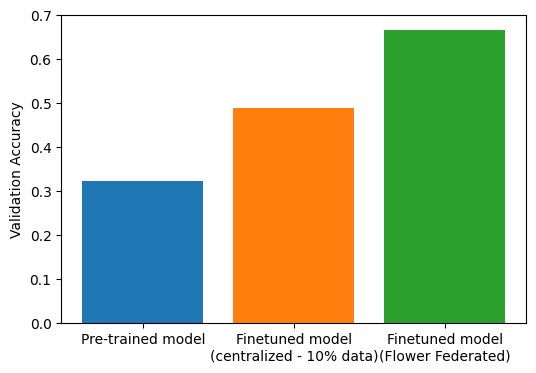

In [32]:
visualize_results(
    results=['7b/pretrained', '7b/cen_10', '7b/fl'])

* See the results if you would provide the same amount of data to the centralized finetuned-model.

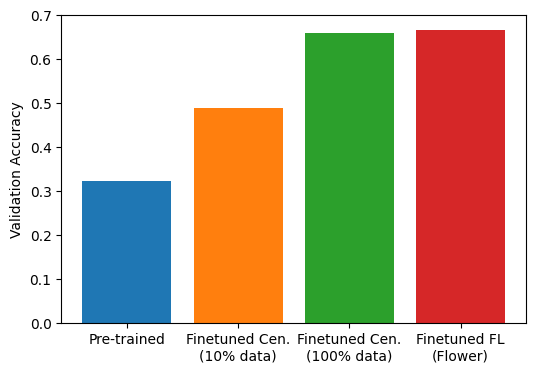

In [18]:
visualize_results(
    results=['7b/pretrained', '7b/cen_10',
             '7b/cen_full', '7b/fl'],
    compact=True)

#### 6. One more analysis

* Compute communication costs.

In [33]:
cfg = get_config("federated")

compute_communication_costs(cfg, comm_bw_mbps=20)

Full model:
	70.623 M parameters
	269.41 MB --> upload in 107.76s @ 20Mbps
Finetuned model:
	0.197 M parameters
	0.75 MB --> upload in 0.30s @ 20Mbps
Federated Learning setting: 
	Number of rounds: 2
	Number of clients per round: 4
-----------------------------------------------
Total Communication costs (Full model): 4.2 GB
Total Communication costs (Finetuning): 12.0 MB
Communication savings: 359.2x
